<a href="https://colab.research.google.com/github/kaisarmasum/Quantum-Machine-Learning/blob/main/Fine_Tuning_Quantum_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine Tuning Quantum-BERT: A Potential N-Qubit Quantum Circuit Evalution for Hybrid Text Classification

In [ ]:
!pip install transformers
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 37.5 MB/s eta 0:00:00


In [ ]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sklearn
print(transformers.__version__)

4.35.2


In [ ]:
print(torch.__version__)

2.1.0+cu121


In [ ]:
print(sklearn.__version__)

1.2.2


In [ ]:
device = torch.device("cpu")
device

device(type='cpu')

In [ ]:
#df = pd.read_csv("/content/Twitter.csv",sep="\t")
df = pd.read_csv("/content/spamdata.csv")
#df = pd.read_csv("/content/IMDB.csv")
#df = pd.read_csv("/content/atis_intents.csv",header=None)
#df.columns = ["label", "text"]
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#from sklearn.preprocessing import LabelEncoder
#l = LabelEncoder()
#df.label = l.fit_transform(df.text)

In [ ]:
df.shape

(5572, 2)

In [ ]:
df = df[:100]

In [ ]:
%%time
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

CPU times: user 5.54 ms, sys: 772 µs, total: 6.31 ms
Wall time: 16.7 ms


In [ ]:
%%time
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

CPU times: user 2.46 s, sys: 1.23 s, total: 3.68 s
Wall time: 7.72 s


<Axes: >

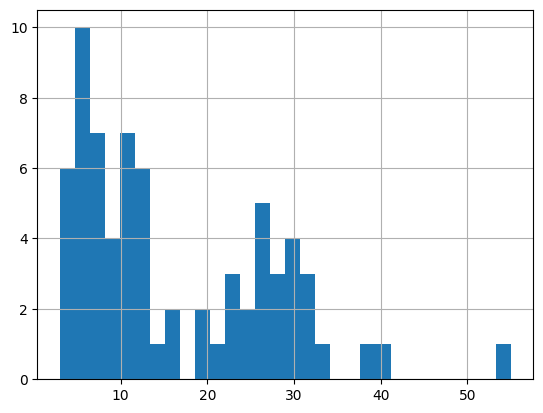

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
%%time
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

CPU times: user 15.9 ms, sys: 2.44 ms, total: 18.4 ms
Wall time: 49.6 ms


In [ ]:
%%time
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

CPU times: user 1.89 ms, sys: 11 µs, total: 1.9 ms
Wall time: 1.83 ms


In [ ]:
%%time
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 128
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

CPU times: user 340 µs, sys: 0 ns, total: 340 µs
Wall time: 346 µs


In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
n_qubits = 2
q_depth = 4
max_layers = 15
q_delta = 0.01

In [ ]:
%%time
dev = qml.device('default.qubit', wires=n_qubits)

CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 6.27 ms


In [ ]:
%%time
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
%%time
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        H_layer(n_qubits)
        RY_layer(q_in)
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        exp_vals = [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]
        return tuple(exp_vals)

CPU times: user 271 µs, sys: 0 ns, total: 271 µs
Wall time: 278 µs


In [ ]:
%%time
class Quantumnet(nn.Module):
    def __init__(self, bert):
        super(Quantumnet, self).__init__()
        self.bert = bert

        self.pre_net = nn.Linear(768, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask,  return_dict=False)

        pre_out = self.pre_net(cls_hs)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(q_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)

CPU times: user 52 µs, sys: 0 ns, total: 52 µs
Wall time: 56.5 µs


In [ ]:
%%time
model = Quantumnet(bert)
model = model.to(device)

CPU times: user 4.17 ms, sys: 18 µs, total: 4.19 ms
Wall time: 4.2 ms


In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = "balanced",
                                 classes = np.unique(train_labels),
                                 y = train_labels)

print(class_wts)

[0.60344828 2.91666667]


In [ ]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)
epochs = 5

In [ ]:
def train():

  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[]
  for step,batch in enumerate(train_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch
    sent_id = sent_id.type(torch.LongTensor)
    mask =  mask.type(torch.LongTensor)
    labels = labels.type(torch.LongTensor)

    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    model.zero_grad()

    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
def evaluate():

  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:

      elapsed = format_time(time.time() - t0)

      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
%%time
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5

Evaluating...

Training Loss: 0.688
Validation Loss: 0.679

 Epoch 2 / 5

Evaluating...

Training Loss: 0.684
Validation Loss: 0.666

 Epoch 3 / 5

Evaluating...

Training Loss: 0.669
Validation Loss: 0.660

 Epoch 4 / 5

Evaluating...

Training Loss: 0.664
Validation Loss: 0.664

 Epoch 5 / 5

Evaluating...

Training Loss: 0.654
Validation Loss: 0.656
CPU times: user 34.2 s, sys: 3.4 s, total: 37.6 s
Wall time: 42.9 s


In [ ]:
%%time
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

CPU times: user 91 ms, sys: 238 ms, total: 329 ms
Wall time: 330 ms


<All keys matched successfully>

In [ ]:
%%time
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

CPU times: user 1.03 s, sys: 18.8 ms, total: 1.05 s
Wall time: 1.05 s


In [ ]:
%%time
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.67      0.15      0.25        13
           1       0.08      0.50      0.14         2

    accuracy                           0.20        15
   macro avg       0.38      0.33      0.20        15
weighted avg       0.59      0.20      0.24        15

CPU times: user 7.87 ms, sys: 0 ns, total: 7.87 ms
Wall time: 8.04 ms


In [ ]:
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,2,11
1,1,1


In [ ]:
%%time
with torch.no_grad():
  preds = model(train_seq.to(device), train_mask.to(device))
  preds = preds.detach().cpu().numpy()

CPU times: user 4.62 s, sys: 262 ms, total: 4.88 s
Wall time: 4.86 s


In [ ]:

preds = np.argmax(preds, axis = 1)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.94      0.26      0.41        58
           1       0.20      0.92      0.33        12

    accuracy                           0.37        70
   macro avg       0.57      0.59      0.37        70
weighted avg       0.81      0.37      0.39        70



In [ ]:
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.23      1.00      0.38         3

    accuracy                           0.33        15
   macro avg       0.62      0.58      0.33        15
weighted avg       0.85      0.33      0.30        15



In [ ]:
df['text'][1]

'Ok lar... Joking wif u oni...'

In [ ]:
df['label'][1]

0

In [ ]:
def load_custom_weights(path, model):
    # Load the .pt file using PyTorch's built-in function
    state_dict = torch.load(path)

    # Access weight groups for pre-net, post-net, and quantum circuit parameters
    pre_net_weights = state_dict["pre_net.weight"]
    post_net_weights = state_dict["post_net.weight"]

    # Extract quantum circuit weights based on specific logic (replace with actual logic)
    # Assuming q_weights is a single tensor for simplicity:
    q_weights = state_dict["q_params"]  # Replace with your actual extraction logic

    # Assign weights to the corresponding model parameters
    model.pre_net.load_state_dict({"weight": pre_net_weights}, strict=False)  # Allow missing bias terms
    model.post_net.load_state_dict({"weight": post_net_weights}, strict=False)  # Allow missing bias terms
    model.q_params = nn.Parameter(q_weights)

    # No need to load weights for BERT layers as they're not part of the loading process

    return model

# Usage example:
model = Quantumnet(bert)
model2 = load_custom_weights("saved_weights.pt", model)

In [ ]:
model2

Quantumnet(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer you used for training
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Adjust model name as needed

def preprocess_text(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Convert tokens to numerical IDs
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Pad or truncate the input to a fixed length
    input_ids = torch.tensor(input_ids)[:512]  # Example length limit
    mask = torch.ones_like(input_ids)

    return input_ids, mask

In [ ]:
!pip install shap

In [ ]:
class Quantumnet(nn.Module):
    def __init__(self, bert):
        super(Quantumnet, self).__init__()
        self.bert = bert

        self.pre_net = nn.Linear(768, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask,  return_dict=False)

        pre_out = self.pre_net(cls_hs)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        q_out = self.q_out  # Adjust if necessary based on your implementation

        # Reshape and normalize for attention map
        attention_map = q_out.reshape(self.n_qubits, self.n_qubits)
        attention_map = torch.nn.functional.softmax(attention_map, dim=1)

        post_net_out = self.post_net(attention_map)
        logits = self.linear(post_net_out)
        prediction = torch.sigmoid(logits)
        for elem in q_in:
          q_out_elem = torch.hstack(q_net(elem, self.q_params)).float().unsqueeze(0)
          q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Adjust model name if needed

def preprocess_text(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Convert tokens to numerical IDs
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Pad or truncate the input to a fixed length
    input_ids = torch.tensor(input_ids)[:512]  # Example length limit
    mask = torch.ones_like(input_ids)

    return input_ids, mask

# Example usage:
text = "This is a sample text."
sent_id, mask = preprocess_text(text)
prediction, attention_map = model(sent_id, mask)

# Visualize attention map
plt.imshow(attention_map.detach().numpy())
plt.colorbar()
plt.title("Attention Map within Quantumnet Module")
plt.show()

In [ ]:
# Visualize attention map
plt.imshow(attention_map.detach().numpy())
plt.colorbar()
plt.title("Attention Map within Quantumnet Module")
plt.show()